In [1]:
import numpy as np
import scipy
import sklearn
from sklearn.decomposition import NMF
from sklearn.cluster import KMeans
from sklearn.mixture import GaussianMixture,BayesianGaussianMixture

import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib as mpl
mpl.rcParams['image.cmap'] = 'Greys'
mpl.rcParams['axes.spines.right'] = False
mpl.rcParams['axes.spines.top'] = False



import sys,os,pdb,copy,pickle
from importlib import reload
# import pynapple as nap

sys.path.append('/mnt/home/szheng/projects/seq_detection2/code')
sys.path.append('/mnt/home/szheng/projects/util_code')
sys.path.append('/mnt/home/szheng/projects/nmf_analysis')
sys.path.append('/mnt/home/szheng/projects/nmf_analysis/scripts')
sys.path.append('/mnt/home/szheng/projects/cluster_spikes')
sys.path.append('/mnt/home/szheng/projects/place_variability/code')
import data_prep_new as dpn
import place_cell_analysis as pa
import plot_helper as ph
import preprocess as prep
import nmf_analysis as na
import nmf_plot as nmfp
reload(na)

import raster_new as rn
import data_prep_pyn as dpp


import change_point_analysis as cpa
import change_point_plot as cpp

import place_field_analysis as pf

import switch_analysis_one_session as saos
reload(saos)

import process_central_arm as pca 
import change_point_analysis_central_arm_seperate as cpacas

import misc
reload(misc)
from misc import get_nth_key, get_nth_val

67 sessions!
67 sessions!


/mnt/home/szheng/ceph/envs/jax/lib/python3.9/site-packages/outdated/utils.py:14: OutdatedPackageWarning: The package pingouin is out of date. Your version is 0.5.2, the latest is 0.5.4.
Set the environment variable OUTDATED_IGNORE=1 to disable these warnings.
  return warn(


In [2]:
import matplotlib
matplotlib.rcParams['svg.fonttype'] = 'none'

In [3]:

figdir = '/mnt/home/szheng/ceph/place_variability/fig/paper/suppfigure_drift'
misc.get_or_create_subdir(figdir)
data_dir = '/mnt/home/szheng/ceph/place_variability/data/paper'
misc.get_or_create_subdir(data_dir)


'/mnt/home/szheng/ceph/place_variability/data/paper'

In [4]:
import database
db = database.db

subdb = db.query('owner=="roman"').sort_values('n_pyr_putative',ascending=False)
subdb = subdb.query('ntrials>=20&n_neurons>=50')
to_exclude_sess = ['e16_3m2_211211']
subdb=subdb.loc[~subdb['sess_name'].isin(to_exclude_sess)]


import pf_recombine_central as pfrc
import fr_map_one_session as fmos
import switch_detection_one_session as sdos
import get_all_switch_add_metrics as gasam

import preprocess_one_session as prepos

In [5]:
fn = 'prepped_data_agg.p'
fn_full = os.path.join(data_dir,fn)
prepped_data_agg = pickle.load(open(fn_full,'rb'))

all_fields_recombined_all = prepped_data_agg['all_fields_recombined_all']
pf_params_recombined_all=  prepped_data_agg['pf_params_recombined_all']
fr_map_trial_df_all= prepped_data_agg['fr_map_trial_df_all']
occu_map_all = prepped_data_agg['occu_map_all']
fr_map_all = prepped_data_agg['fr_map_all']

pval_all = prepped_data_agg['pval_all']
X_pwc_all = prepped_data_agg['X_pwc_all']
X_raw_all = prepped_data_agg['X_raw_all']
changes_df_all = prepped_data_agg['changes_df_all']
var_res_all_test = prepped_data_agg['var_res_all']
# corr_all = prepped_data_agg['corr_all']
all_sw_d_all = prepped_data_agg['all_sw_d_all']
all_sw_with_metrics_d_all = prepped_data_agg['all_sw_with_metrics_d_all']
best_n_all_test = prepped_data_agg['best_n_all']
spk_beh_df_all = prepped_data_agg['spk_beh_df_all']

pf_params_all = prepped_data_agg['pf_params_all']
all_fields_all = prepped_data_agg['all_fields_all']

ntrials_per_tt=fr_map_trial_df_all.groupby(level=(0,1,2,3)).apply(lambda x:x.dropna(axis=1,how='all').shape[1])
ntrials_mask = ntrials_per_tt.groupby(level=(0,1,2)).apply(lambda x:(x>=7).all()) 



In [6]:
savefn_full = os.path.join(data_dir,'per_field_metrics_shtest_with_1cp.p')
# pickle.dump(per_field_metrics_all,open(savefn_full,'wb'))
per_field_metrics_all=pickle.load(open(savefn_full,'rb'))

# pv decorr

In [7]:
pc_ind_l = []
for ind in all_fields_recombined_all.index:
    if ind[3]=='both':
        pc_ind_l.append((ind[0],ind[1],ind[2],0,ind[4]))
        pc_ind_l.append((ind[0],ind[1],ind[2],1,ind[4]))
    else:
        pc_ind_l.append((ind[0],ind[1],ind[2],ind[3],ind[4]))
pc_ind_l = pd.MultiIndex.from_tuples(pc_ind_l)

# select place cells
fr_map_trial_df_pc = fr_map_trial_df_all.unstack(level=-1).loc[pc_ind_l].stack()

import pv_corr_analysis as pvca

# pv_corr_alltrials = fr_map_trial_df_pc.groupby(level=(0,1,2,3)).corr()
# gpb_corr_sess=pv_corr_alltrials.groupby(level=(0,1,2,3))
# pv_corr_per_lag=gpb_corr_sess.apply(pvca.get_val_per_lag)

In [8]:
zscore_one_neuron = lambda x:(x - np.nanmean(x)) / np.nanstd(x)
def get_pv_corr_per_lag_all_sess(fr_map_trial_df_pc,do_zscore=False):
    df = fr_map_trial_df_pc
    if do_zscore:
        fr_map_trial_df_pc_z = fr_map_trial_df_pc.groupby(level=(0,1,2,3,4)).apply(zscore_one_neuron)
        df = fr_map_trial_df_pc_z
    pv_corr_alltrials = df.groupby(level=(0,1,2,3)).corr()
    gpb_corr_sess=pv_corr_alltrials.groupby(level=(0,1,2,3))
    pv_corr_per_lag=gpb_corr_sess.apply(pvca.get_val_per_lag)
    return pv_corr_per_lag

In [9]:
fr_map_trial_df_pc_z = fr_map_trial_df_pc.groupby(level=(0,1,2,3,4)).apply(zscore_one_neuron)


In [10]:
pv_corr_per_lag_z = get_pv_corr_per_lag_all_sess(fr_map_trial_df_pc,do_zscore=True)


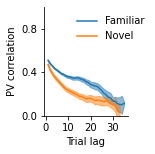

In [11]:
gpb = pv_corr_per_lag_z.groupby(level=(2))
fig,ax=plt.subplots(figsize=(1.5,2))
isfam_d_str={0:'Familiar',1:'Novel'}
color_l = ['C0','C1']
for k,val in gpb:
    c = color_l[k]
    fig,ax=ph.mean_error_plot(val,fig=fig,ax=ax,label=f'{isfam_d_str[k]}',linestyle='-',c=c)
sns.despine()
ax.legend(bbox_to_anchor=[1.3,1],frameon=False)
ax.set_ylim([0,1])
ax.set_xlabel('Trial lag')
ax.set_ylabel('PV correlation')
ax.set_yticks(np.arange(0,1,0.4))
ax.set_xticks([0,10,20,30])

figfn = 'pv_corr_zscored_fam_nov_vs_triallag'
ph.save_given_name(fig,figfn,figdir)


In [101]:
axs[0,0].get_xticks()

array([ 1.,  0., 25., 50.])

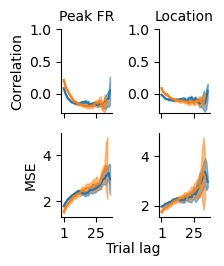

In [104]:
reload(pvca)
# pf_key = 'fr_peak'
fig,axs=plt.subplots(2,2,figsize=(2.3,2.9),sharex=True)
sns.despine()
dist = 'mse'
for ii,pf_key in enumerate(['fr_peak','peak']):
    ax=axs[0,ii]
    fig,ax,pf_key_corr_allsess = pvca.get_plot_pf_param_population_corr_vs_lag(pf_params_all,ma_ind_new=None,pf_key=pf_key,fig=fig,ax=ax,center_cell=False,zscore_cell=True,dist='corr')
    ax.set_ylim([-0.3,1.])
    ax.legend().remove()
    ax.set_xlabel('')
    ax.set_ylabel('')
        
    ax=axs[1,ii]
    #     fig,ax,pf_key_corr_allsess = pvca.get_plot_pf_param_population_corr_vs_lag(pf_params_all,ma_ind_new=None,pf_key=pf_key,fig=fig,ax=ax,center_cell=False,zscore_cell=True,dist=dist)
    fig,ax,pf_key_mse_allsess = pvca.get_plot_pf_param_population_corr_vs_lag(pf_params_all,ma_ind_new=None,pf_key=pf_key,fig=fig,ax=ax,center_cell=False,zscore_cell=True,dist='mse')
    ax.legend().remove()
    
    ax.set_xlabel('')
    ax.set_ylabel('')
    
axs[0,0].set_title('Peak FR')
axs[0,1].set_title('Location')
axs[0,0].set_ylabel('Correlation')
axs[1,0].set_ylabel('MSE')
axs[1,0].set_xticks([1,25])
axs[0,1].set_xticks([1,25])
sxl=fig.supxlabel('Trial lag',fontsize=10)
sxl.set_position((0.6,0.1))

plt.tight_layout()
figfn = f'corr_and_mse_vs_triallag_zscored'
ph.save_given_name(fig,figfn,figdir)

    

# individual neuron ratemap_corr, peak fr mse, peak mse

In [72]:
%%time
gpb=fr_map_trial_df_pc.groupby(level=(0,1,2,3,4))
rmcorr_per_neuron = gpb.corr()

CPU times: user 4.04 s, sys: 122 ms, total: 4.17 s
Wall time: 4.17 s


In [78]:
%%time
corr_all = {}
corr_per_lag_all = {}
for k,val in gpb:
    corr_one =val.corr().dropna(axis=1,how='all').dropna(axis=0,how='all')
    corr_all[k] = corr_one
    corr_per_lag_one = pvca.get_val_per_lag(corr_one)
    corr_per_lag_all[k] = corr_per_lag_one
corr_all = pd.concat(corr_all,axis=0)
corr_per_lag_all = pd.concat(corr_per_lag_all,axis=0)

CPU times: user 1min 23s, sys: 497 ms, total: 1min 24s
Wall time: 1min 24s


In [88]:
corr_per_lag_all.groupby(level=4).mean()

,1,2,3,4,5,6,7,8,9,10,...,26,27,28,29,30,31,32,33,34,35
1.0,0.378311,0.384541,0.371003,0.328295,0.355664,0.323577,0.301169,0.265740,0.235499,0.265091,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2.0,0.529304,0.528150,0.506339,0.485733,0.486778,0.475074,0.445683,0.460873,0.411402,0.427257,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3.0,0.552065,0.545790,0.518435,0.514735,0.485251,0.474383,0.458554,0.453989,0.480299,0.473123,...,0.430943,0.461526,0.424713,0.500461,0.444891,0.490407,0.412813,0.473046,NaN,NaN
4.0,0.561051,0.536029,0.522267,0.505711,0.503322,0.526972,0.525267,0.515279,0.495598,0.477353,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
5.0,0.534706,0.528863,0.512236,0.496623,0.477771,0.457232,0.418655,0.413872,0.427458,0.405246,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
474.0,0.621605,0.566896,0.554291,0.566240,0.528006,0.510891,0.574036,0.570724,0.594929,0.571357,...,0.313011,0.339795,0.329311,0.382856,0.301721,0.383755,0.375397,0.296444,0.308943,0.227073
475.0,0.805875,0.785863,0.772779,0.742035,0.694989,0.717160,0.718282,0.691023,0.694612,0.704952,...,0.200801,0.269614,0.175590,0.158256,0.073380,0.044718,NaN,NaN,NaN,NaN
476.0,0.448818,0.384523,0.339732,0.269931,0.207404,0.190258,0.211382,0.125896,0.117949,0.072307,...,-0.124309,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
479.0,0.309384,0.319312,0.268429,0.197252,0.190460,0.231420,0.174216,0.044985,0.044889,0.151597,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [96]:
# corr_per_lag_per_sess=corr_per_lag_all.groupby(level=(0,1,2)).mean()
corr_per_lag_per_sess_per_trpair=corr_per_lag_all.groupby(level=(0,1,2,5)).mean()

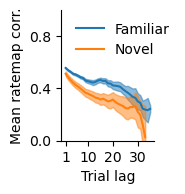

In [99]:
df  = corr_per_lag_per_sess_per_trpair#corr_per_lag_per_sess
gpb = df.groupby(level=(2))
fig,ax=plt.subplots(figsize=(1.2,1.7))
isfam_d_str={0:'Familiar',1:'Novel'}
color_l = ['C0','C1']
for k,val in gpb:
    c = color_l[k]
    fig,ax=ph.mean_error_plot(val,fig=fig,ax=ax,label=f'{isfam_d_str[k]}',linestyle='-',c=c)
sns.despine()
ax.legend(bbox_to_anchor=[1.3,1],frameon=False)
ax.set_ylim([0,1])
ax.set_xlabel('Trial lag')
ax.set_ylabel('Mean ratemap corr.')
ax.set_yticks(np.arange(0,1,0.4))
ax.set_xticks([1,10,20,30])

figfn = 'mean_rm_corr_fam_nov_vs_triallag'
ph.save_given_name(fig,figfn,figdir)


In [98]:
corr_per_lag_per_sess_per_trpair

1         2         3         4   \
e13_16f1 e13_16f1_210302 0 0   0.405741  0.397976  0.353839  0.352226   
                           1   0.528259  0.510897  0.489859  0.471256   
                           2   0.579634  0.492707  0.510448  0.457391   
                           3   0.584119  0.560353  0.579397  0.520216   
                           4   0.603813  0.544217  0.498550  0.546440   
...                                 ...       ...       ...       ...   
e16_3m2  e16_3m2_211213  1 10  0.519315  0.612644  0.600416  0.651633   
                           11  0.558186  0.550725  0.554990  0.486041   
                           12  0.622208  0.603463  0.479724       NaN   
                           13  0.621840  0.566600       NaN       NaN   
                           14  0.537963       NaN       NaN       NaN   

                                     5         6         7         8   \
e13_16f1 e13_16f1_210302 0 0   0.358303  0.272076  0.235896  0.248928   
                           1   0.466491  0.488191  0.548327  0.428478   
                           2   0.486503  0.520538  0.473804  0.408188   
                           3   0.552814  0.523413  0.434391  0.564332   
                           4   0.459272  0.405723  0.478815  0.434123   
...                                 ...       ...       ...       ...   
e16_3m2  e16_3m2_211213  1 10  0.540073       NaN       NaN       NaN   
                           11       NaN       NaN       NaN       NaN   
                           12       NaN       NaN       NaN       NaN   
                           13       NaN       NaN       NaN       NaN   
                           14       NaN       NaN       NaN       NaN   

                                     9         10  ...  26  27  28  29  30  \
e13_16f1 e13_16f1_210302 0 0   0.218724  0.179598  ... NaN NaN NaN NaN NaN   
                           1   0.436256  0.503182  ... NaN NaN NaN NaN NaN   
                           2   0.472669  0.400870  ... NaN NaN NaN NaN NaN   
                           3   0.509808  0.505357  ... NaN NaN NaN NaN NaN   
                           4   0.481171  0.476589  ... NaN NaN NaN NaN NaN   
...                                 ...       ...  ...  ..  ..  ..  ..  ..   
e16_3m2  e16_3m2_211213  1 10       NaN       NaN  ... NaN NaN NaN NaN NaN   
                           11       NaN       NaN  ... NaN NaN NaN NaN NaN   
                           12       NaN       NaN  ... NaN NaN NaN NaN NaN   
                           13       NaN       NaN  ... NaN NaN NaN NaN NaN   
                           14       NaN       NaN  ... NaN NaN NaN NaN NaN   

                               31  32  33  34  35  
e13_16f1 e13_16f1_210302 0 0  NaN NaN NaN NaN NaN  
                           1  NaN NaN NaN NaN NaN  
                           2  NaN NaN NaN NaN NaN  
                           3  NaN NaN NaN NaN NaN  
                           4  NaN NaN NaN NaN NaN  
...                            ..  ..  ..  ..  ..  
e16_3m2  e16_3m2_211213  1 10 NaN NaN NaN NaN NaN  
                           11 NaN NaN NaN NaN NaN  
                           12 NaN NaN NaN NaN NaN  
                           13 NaN NaN NaN NaN NaN  
                           14 NaN NaN NaN NaN NaN  

[825 rows x 35 columns]